In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
from collections import Counter
import pandas as pd
import numpy as np

'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, normalisation, evaluation, Neptune_data_read
from parameter import *
from dspike_formulas import *

import pylab as plt

/Users/matthias/anaconda/lib/python2.7/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory
  stacklevel=stacklevel + 1):


In [20]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-09-20_DS_mixtures/"
files_start = 8383
files_end = 8516

In [15]:
# Isotopes used for Spike Inversion [[denominator isotope], nominator isotopes, .. ]
spikeSn_ls = [["117"],["118", "122", "124"]]
# Dictionary with pure DS composition
spike_dict_117_122_meas = {"118": 0.0102951622334242, "119": 0.0090731830784630, "120" : 0.0338645175569080, "122" : 0.8068023572167630, "124" : 0.0114846216495240} # DS compositon 1ppm - 15.09.17
# Dictionary with Standard composition
meas_dict = { "118" : 3.15777585757689, "119" : 1.11972979701600, "120" : 4.25050484928267, "122" : 0.60392336483548, "124" : 0.754692491283485} # mean of 1ppm NIST Std used for calib-15.09.17
# Denominator isotope in ratios for DS & Std composition
meas_denom_117 = "117"

# Load compositions in for DS inversion
Sn_meas_obj = load_ratio_dict(meas_dict_NIST_117, meas_denom_117)
spike_obj = load_ratio_dict(spike_dict_117_122_meas, meas_denom_117)


In [91]:
# cup configuration
#cup_config = cycle_Sb
Sn_isotopes = ["117", "118", "119", "120", "122", "124"]
cup_config = cycles_spike

# Mass Range of cup configuration
mass_range = cycle_Sn_spike_mass_range

# Isotopes used for Interference correction
corr_isotopes_2 = {"Te" : "125", "Xe" : "129"}
#corr_isotopes_2 = {}
#corr_isotopes_Sb = {"Te": "125"}

denom_isotope = "117"
Sn_monitor = ["125"]

#def eval_iso_list(isotopes_list, denom_isotope, monitor_iso):
#    isotope_den = denom_isotope
#    isotopes_list.remove(isotope_den)
#    for i in range(len(monitor_iso)):
#        isotopes_list.append(monitor_iso[i])
#    isotopes_list.sort()
#   return isotopes_list

#isotope_ls = eval_iso_list(Sn_isotopes, denom_isotope, Sn_monitor)

#data_sample_column = [(i + "/" + denom_isotope) for i in isotope_ls]    
isotopes = [["118", "119", "120", "122", "124"]]

# Amount of interations for estimation of instrumental and natural fractionation
loop_nat = 3
loop_ins = 6
# assumended instrumental and natural fractionation
start_nat = -0.1 #start_nat = -0.1
start_ins = -2 #start_ins = 2
# isotope ratio used for calculation of instrumental and natural fractionation [denominator[x, y, z]] e.g. [117,[118, 122, 124]] x = 118/117
inv_iso_ratio = 'x'

# Mass fractionation law ("exp" or "GPL")
law = "exp"

# n for GPL
n_GPL_ins = 0.1
n_GPL_nat = 0.001

# Interference_corr on the denominator isotope
isotope_denom_corr = False
# background correction
blk_corr = True

In [17]:
mass_range.get_graph_of_corr(corr_isotopes_2)["124"]

{'125', '129'}

In [18]:
mass_range.get_order_of_corr(corr_isotopes_2)

[{'117', '118', '119', '121', '125', '127', '129', '131'},
 {'120', '122', '123', '124', '126'}]

In [21]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
#files_1 = range(5552,5623,1) + range(5632,5729, 1)

for sample in files_1:
    
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)

#for x in [123]:
#    sample_ls.remove(x)
#blk_ls = blk_ls[0::5]
#blk_ls.remove(5234)

In [22]:
df_all

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),Ax (1),L1 (1),L2 (1),L3 (1),L4 (1)
date,,,,,,,,,,,,,,,
2017-09-21 14:50:00,1,blank sol,0.011327,0.013713,0.016516,0.001898,0.000698,0.000653,0.000676,0.000391,0.000778,0.002825,0.000239,0.000692,0.000238
2017-09-21 14:50:00,2,blank sol,0.011268,0.013695,0.016473,0.001906,0.000679,0.000659,0.000672,0.000382,0.000785,0.002781,0.000256,0.000693,0.000221
2017-09-21 14:50:00,3,blank sol,0.011297,0.013676,0.016506,0.001910,0.000701,0.000657,0.000664,0.000360,0.000801,0.002811,0.000240,0.000661,0.000226
2017-09-21 14:50:00,4,blank sol,0.011287,0.013719,0.016464,0.001894,0.000672,0.000645,0.000700,0.000374,0.000780,0.002801,0.000235,0.000685,0.000247
2017-09-21 14:50:00,5,blank sol,0.011269,0.013682,0.016416,0.001892,0.000655,0.000677,0.000690,0.000362,0.000773,0.002768,0.000261,0.000677,0.000230
2017-09-21 14:50:00,6,blank sol,0.011299,0.013751,0.016432,0.001887,0.000673,0.000673,0.000679,0.000401,0.000781,0.002868,0.000269,0.000744,0.000247
2017-09-21 14:50:00,7,blank sol,0.011338,0.013773,0.016463,0.001902,0.000673,0.000685,0.000671,0.000383,0.000798,0.002908,0.000267,0.000761,0.000248
2017-09-21 14:50:00,8,blank sol,0.011314,0.013752,0.016503,0.001902,0.000674,0.000656,0.000668,0.000386,0.000780,0.002794,0.000258,0.000675,0.000219
2017-09-21 14:50:00,9,blank sol,0.011304,0.013716,0.016420,0.001886,0.000687,0.000650,0.000679,0.000389,0.000792,0.002770,0.000231,0.000664,0.000216


In [92]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_DS_inv= pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    
    # arbitrary blank positions - check blk position before and after sample 
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True #if True blank corr_activated
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    # Background correction
    if (blk_corr == True) and (blk_corr_sample == True):
        # Reads signals of Blank measurements
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio, law, n_GPL_ins)
        # Outlier correction on signals of blank measurements
        df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        # Background substraction of blank signals
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    
    # No background correction
    else:
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio, law, n_GPL_ins)
    
    # Gives zero_corrected Signals back & writes it in a dataframe
    data_sample_raw = new_corr.raw_signals_all()
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    #Get raw ratios
    data_sample = new_corr.raw_ratios(denom_isotope)
    # raw ratios from dataframe in dictionary for data handling
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    # First DS-inversion without interference correction
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope, law, n_GPL_ins, n_GPL_nat)
    data_spike_calc = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    # Beta for interference correction
    beta = data_spike_calc["frac_ins_x2.5"]
    # Interference correction
    spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    # interference corrected raw ratios
    data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')
    # Second DS-inversion
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope, law, n_GPL_ins, n_GPL_nat)
    data_spike_calc_2 = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    #Calculation of eSn
    data_spike_calc_2["eSn_118"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
    data_spike_calc_2["eSn_122"] = ((data_spike_calc_2["Nr2:y"]/data_spike_calc_2["n0:y"])-1)*10000
    data_spike_calc_2["eSn_124"] = ((data_spike_calc_2["Nr2:z"]/data_spike_calc_2["n0:z"])-1)*10000
    data_spike_calc_2["eSn_122_118"] = (((data_spike_calc_2["Nr2:y"]/data_spike_calc_2["Nr2:x"])/(data_spike_calc_2["n0:y"]/data_spike_calc_2["n0:x"]))-1)*10000
    data_spike_calc_2["eSn_124_118"] = (((data_spike_calc_2["Nr2:z"]/data_spike_calc_2["Nr2:x"])/(data_spike_calc_2["n0:z"]/data_spike_calc_2["n0:x"]))-1)*10000
    data_spike_calc_2["fsam"] = 1/((data_spike_calc_2["Mr2.5:x"]*0.07669971 - 0.24220048)/(0.00525699 - data_spike_calc_2["Mr2.5:x"]*0.51062751)+1)
    data_spike_calc_2["fspike"] = 1-data_spike_calc_2["fsam"]
    data_spike_calc_2["Q"] = data_spike_calc_2["fsam"]/data_spike_calc_2["fspike"]
    #Outlier rejection
    data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)
    
    # Extraction of Sample Name, Date, Measurement time and add it to Dataframe
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_spike_calc_2["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_spike_calc_2["sample"] = sample_name
    data_spike_calc_2["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_spike_calc_2 = data_spike_calc_2.merge(data_sample_raw)
    
    # Add each sample in for loop to a dataframe
    df_DS_inv = df_DS_inv.append(data_spike_calc_2)

In [82]:
df_DS_inv = df_DS_inv.set_index("date")
columns = ["cycle", "sample", "eSn_118", "eSn_122", "eSn_124", "eSn_122_118","eSn_124_118", "Q"]
columns.extend(df_DS_inv.drop(["cycle", "sample", "eSn_118", "eSn_122", "eSn_124", "eSn_122_118", "eSn_124_118", "Q", "121", "123", "127", "131"], axis=1).columns)
df_DS_inv_sub = pd.DataFrame(df_DS_inv, columns = columns)

#df_internal_sub["Cd/Sn"] = (df_internal_norm["111"]/12.722)/(df_internal_norm["118"]/24.223)
df_DS_inv_sub["Te/Sn_nat"] = (df_DS_inv["125"]/7.0509)/(df_DS_inv["118"]/24.223)

#df_internal_sub["Te/Sn"] = (df_internal_norm["126"]/18.8066)/(df_internal_norm["118"]/24.223)
#df_internal_sub = df_internal_sub[df_internal_sub["118"] >= 7]
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")
df_DS_inv_sub

,cycle,sample,eSn_118,eSn_122,eSn_124,eSn_122_118,eSn_124_118,Q,n0:x,n0:y,...,122,120,117,124,125,126,129,119,118,Te/Sn_nat
date,,,,,,,,,,,,,,,,,,,,,
2017-09-21 14:55:00,1,NIST + DS opt. 0.6-0.4,-1.479231,-7.281758,-10.112106,-5.803386,-8.634152,1.544807,3.157776,0.603923,...,8.985967,9.419090,10.913953,1.817759,-4.738737e-06,-3.240616e-05,-1.691918e-04,2.449528,6.674693,-2.439016e-06
2017-09-21 14:55:00,2,NIST + DS opt. 0.6-0.4,-1.719013,-8.461725,-11.750444,-6.743872,-10.033156,1.544908,3.157776,0.603923,...,9.274815,9.721543,11.263996,1.876143,-3.896375e-07,-4.043806e-05,-1.450718e-04,2.528048,6.889254,-1.942996e-07
2017-09-21 14:55:00,3,NIST + DS opt. 0.6-0.4,-1.662635,-8.184300,-11.365257,-6.522750,-9.704235,NaN,3.157776,0.603923,...,9.671461,10.139140,11.746737,1.956694,-1.620184e-05,-1.987646e-05,-2.551380e-05,2.636651,7.185631,-7.746093e-06
2017-09-21 14:55:00,4,NIST + DS opt. 0.6-0.4,-1.409039,-6.936322,-9.632466,-5.528062,-8.224586,1.544879,3.157776,0.603923,...,9.790554,10.263196,11.892101,1.980606,1.768216e-05,-2.632826e-05,8.341200e-06,2.668969,7.273049,8.352226e-06
2017-09-21 14:55:00,5,NIST + DS opt. 0.6-0.4,-1.515640,-7.460935,-10.360890,-5.946196,-8.846590,1.544983,3.157776,0.603923,...,9.703110,10.171436,11.785434,1.962961,2.056366e-05,-1.618606e-05,-5.939880e-05,2.645142,7.208272,9.800600e-06
2017-09-21 14:55:00,6,NIST + DS opt. 0.6-0.4,-1.663855,-8.190304,-11.373593,-6.527535,-9.711353,NaN,3.157776,0.603923,...,9.667698,10.139148,11.741510,1.956723,5.156263e-06,-8.434358e-06,-7.710780e-05,2.636653,7.185220,2.465348e-06
2017-09-21 14:55:00,7,NIST + DS opt. 0.6-0.4,-1.576062,-7.758275,-10.773740,-6.183188,-9.199128,1.544961,3.157776,0.603923,...,9.605133,10.068231,11.666062,1.943075,-5.865537e-06,-1.130146e-05,-7.007080e-05,2.618280,7.135234,-2.824119e-06
2017-09-21 14:55:00,8,NIST + DS opt. 0.6-0.4,-1.538694,-7.574387,-10.518416,-6.036622,-8.981104,1.544831,3.157776,0.603923,...,9.463980,9.920339,11.495165,1.914395,7.217863e-06,-2.404516e-05,4.162000e-07,2.579808,7.030160,3.527173e-06
2017-09-21 14:55:00,9,NIST + DS opt. 0.6-0.4,-1.236264,-6.086004,-8.451770,-4.850340,-7.216398,1.544985,3.157776,0.603923,...,9.263322,9.711853,11.253202,1.874092,8.024763e-06,-1.724116e-05,-6.178800e-06,2.525698,6.882483,4.005626e-06


In [83]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_DS_inv_mean = df_DS_inv_sub.drop("cycle", axis=1).groupby(df_DS_inv_sub.index).mean()
df_DS_inv_mean_sd = df_DS_inv_sub.drop("cycle", axis=1).groupby(df_DS_inv_sub.index).agg([np.mean, SD2])
df_DS_inv_mean["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
df_DS_inv_mean_sd["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
#df_internal_norm_mean = df_internal_norm_mean[df_internal_norm_mean["118"] >= 7]
df_DS_inv_mean_sd
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

eSn_118             eSn_122              eSn_124  \
                         mean       SD2      mean       SD2       mean   
date                                                                     
2017-09-21 14:55:00 -1.515333  0.403452 -7.459384  1.985468 -10.358709   
2017-09-21 15:11:00 -1.545675  0.375053 -7.608707  1.845733 -10.566045   
2017-09-21 15:27:00 -1.515289  0.487383 -7.459152  2.398574 -10.358375   
2017-09-21 15:43:00 -1.517062  0.495063 -7.467871  2.436379 -10.370480   
2017-09-21 16:00:00 -1.438827  0.401323 -7.082881  1.975035  -9.835938   
2017-09-21 16:16:00 -1.490430  0.581167 -7.336788  2.860102 -10.188459   
2017-09-21 16:32:00 -1.495869  0.386084 -7.363604  1.899962 -10.225723   
2017-09-21 16:48:00 -1.454910  0.528026 -7.161999  2.598634  -9.945774   
2017-09-21 17:04:00 -1.537806  0.451374 -7.569967  2.221235 -10.512245   
2017-09-21 17:20:00 -0.763938  0.405962 -3.761100  1.998351  -5.223332   
2017-09-21 17:37:00 -1.519947  0.460880 -7.482077  2.268114 -10.390211   
2017-09-21 17:53:00 -1.505922  0.521892 -7.413047  2.568323 -10.294354   
2017-09-21 18:10:00 -1.512297  0.293302 -7.444462  1.443394 -10.338003   
2017-09-21 18:26:00 -1.490489  0.434854 -7.337114  2.140003 -10.188936   
2017-09-21 18:48:00 -1.536684  0.473884 -7.564440  2.332068 -10.504569   
2017-09-21 19:04:00 -1.454292  0.337657 -7.159000  1.661697  -9.941638   
2017-09-21 19:21:00 -1.479686  0.456859 -7.283946  2.248289 -10.115109   
2017-09-21 19:37:00 -1.517863  0.415914 -7.471834  2.046765 -10.375995   
2017-09-21 19:53:00 -1.503363  0.488715 -7.400461  2.405061 -10.276883   
2017-09-21 20:09:00 -1.446395  0.295434 -7.120143  1.453875  -9.887689   
2017-09-21 20:25:00 -1.480755  0.392908 -7.289219  1.933628 -10.122439   
2017-09-21 20:41:00 -1.474991  0.261700 -7.260878  1.287889 -10.083102   
2017-09-21 20:57:00 -1.321831  0.542733 -6.507062  2.671018  -9.036381   
2017-09-21 21:13:00 -1.407832  0.409522 -6.930340  2.015446  -9.624132   
2017-09-21 21:30:00 -0.684143  0.233839 -3.368317  1.151112  -4.677895   
2017-09-21 21:46:00 -1.438750  0.385666 -7.082504  1.897964  -9.835417   
2017-09-21 22:02:00 -1.431153  0.331216 -7.045129  1.630039  -9.783527   
2017-09-21 22:18:00 -1.480078  0.464637 -7.285874  2.286579 -10.117785   
2017-09-21 22:34:00 -1.385516  0.350250 -6.820528  1.723766  -9.471664   
2017-09-21 22:50:00 -1.472351  0.433321 -7.247857  2.132420 -10.065002   
...                       ...       ...       ...       ...        ...   
2017-09-22 00:43:00 -1.465560  0.436174 -7.214433  2.146420 -10.018593   
2017-09-22 00:59:00 -1.450873  0.448685 -7.142155  2.208115  -9.918233   
2017-09-22 01:15:00 -1.427639  0.409757 -7.027821  2.016584  -9.759486   
2017-09-22 01:31:00 -1.482733  0.474963 -7.298940  2.337495 -10.135926   
2017-09-22 01:47:00 -0.722335  0.338463 -3.556315  1.666099  -4.938959   
2017-09-22 02:04:00 -1.423306  0.462538 -7.006483  2.276279  -9.729851   
2017-09-22 02:20:00 -1.509428  0.516265 -7.430302  2.540525 -10.318313   
2017-09-22 02:36:00 -1.460638  0.452707 -7.190210  2.227880  -9.984957   
2017-09-22 02:52:00 -1.502379  0.366795 -7.395640  1.805080 -10.270207   
2017-09-22 03:08:00 -1.485624  0.340393 -7.313193  1.675167 -10.155733   
2017-09-22 03:24:00 -1.506172  0.588019 -7.414257  2.893707 -10.296022   
2017-09-22 03:40:00 -1.459591  0.461953 -7.185055  2.273385  -9.977799   
2017-09-22 03:56:00 -1.423130  0.374586 -7.005633  1.843462  -9.728682   
2017-09-22 04:13:00 -1.479798  0.459463 -7.284497  2.261127 -10.115873   
2017-09-22 04:29:00 -1.439294  0.397627 -7.085179  1.956855  -9.839129   
2017-09-22 04:45:00 -1.454532  0.372144 -7.160175  1.831425  -9.943265   
2017-09-22 05:01:00 -1.377107  0.293423 -6.779150  1.444088  -9.414216   
2017-09-22 05:17:00 -1.444247  0.557889 -7.109519  2.745573  -9.872900   
2017-09-22 05:33:00 -1.347826  0.659038 -6.634961  3.243182  -9.213950   
2017-09-22 05:49:00 -1.412051  0.454880 -6.951096  2.238649  -9.652946   
2017-09-22 06:05:00 -0.589

In [84]:
df_DS_inv_mean_sample_sd = df_DS_inv_mean.groupby(df_DS_inv_mean["sample"]).agg([np.mean, SD2])
df_DS_inv_mean_sample_sd

eSn_118             eSn_122              eSn_124  \
                             mean       SD2      mean       SD2       mean   
sample                                                                       
NIST + DS 0.4-0.6       -1.471465  0.093231 -7.243505  0.458808 -10.058968   
NIST + DS 0.5-0.5       -1.464930  0.074734 -7.211329  0.367767 -10.014281   
NIST + DS 0.7-0.3       -1.453463  0.089933 -7.154897  0.442557  -9.935927   
NIST + DS 0.8-0.2       -1.388052  0.109729 -6.832961  0.540047  -9.488898   
NIST + DS opt. 0.6-0.4  -1.464999  0.082891 -7.211674  0.407917 -10.014765   
SPEX1 + DS opt. 0.6-0.4 -0.689926  0.129189 -3.396769  0.635961  -4.717396   

                                  eSn_122_118           eSn_124_118            \
                              SD2        mean       SD2        mean       SD2   
sample                                                                          
NIST + DS 0.4-0.6        0.637049   -5.772903  0.365687   -8.588787  0.543982   
NIST + DS 0.5-0.5        0.510630   -5.747261  0.293127   -8.550633  0.436036   
NIST + DS 0.7-0.3        0.614471   -5.702283  0.352739   -8.483726  0.524708   
NIST + DS 0.8-0.2        0.749882   -5.445695  0.430427   -8.102015  0.640315   
NIST + DS opt. 0.6-0.4   0.566385   -5.747535  0.325126   -8.551045  0.483642   
SPEX1 + DS opt. 0.6-0.4  0.883156   -2.707042  0.506845   -4.027766  0.754075   

                           ...          126                 129            \
                           ...         mean       SD2      mean       SD2   
sample                     ...                                              
NIST + DS 0.4-0.6          ...    -0.000015  0.000019 -0.000166  0.000357   
NIST + DS 0.5-0.5          ...    -0.000006  0.000023  0.000077  0.000210   
NIST + DS 0.7-0.3          ...    -0.000012  0.000008 -0.000303  0.000876   
NIST + DS 0.8-0.2          ...    -0.000014  0.000015 -0.000025  0.000089   
NIST + DS opt. 0.6-0.4     ...    -0.000010  0.000022 -0.000131  0.001237   
SPEX1 + DS opt. 0.6-0.4    ...    -0.000021  0.000017 -0.001533  0.004313   

                              119                 118               Te/Sn_nat  \
                             mean       SD2      mean       SD2          mean   
sample                                                                          
NIST + DS 0.4-0.6        2.726384  0.072457  7.255146  0.193245 -3.096538e-06   
NIST + DS 0.5-0.5        2.597555  0.077697  7.007554  0.209937 -1.488739e-06   
NIST + DS 0.7-0.3        2.445862  0.066603  6.712862  0.183090  5.219520e-07   
NIST + DS 0.8-0.2        2.403986  0.054553  6.634155  0.150672  1.105543e-07   
NIST + DS opt. 0.6-0.4   2.438944  0.095295  6.645978  0.259716 -6.915546e-07   
SPEX1 + DS opt. 0.6-0.4  2.230858  0.051899  6.057865  0.141068  4.404329e-07   

                                   
                              SD2  
sample                             
NIST + DS 0.4-0.6        0.000004  
NIST + DS 0.5-0.5        0.000007  
NIST + DS 0.7-0.3        0.000009  
NIST + DS 0.8-0.2        0.000008  
NIST + DS opt. 0.6-0.4   0.000008  
SPEX1 + DS opt. 0.6-0.4  0.000008  

[6 rows x 660 columns]

In [85]:
std_used = "NIST + DS opt. 0.6-0.4 "
sub_index = df_DS_inv_mean[(df_DS_inv_mean["sample"].shift(1) == df_DS_inv_mean["sample"].shift(-1)) & (df_DS_inv_mean["sample"].shift(1) == std_used)].index
corr_values = df_DS_inv_mean[df_DS_inv_mean["124"] >= 0.1]
corr_values_2 = corr_values[corr_values["sample"] == std_used]
#corr_values_2 = corr_values[corr_values["sample"] == std_used]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]
#std_mean = corr_values[(corr_values["sample"] == std_used)].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new - ((new.shift(1) + new.shift(-1))/2)))
epsilon_2 = ((new_2 - ((new_2.shift(1) + new_2.shift(-1))/2)))
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample_2

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != std_used]
epsilon_2 = epsilon_2[epsilon_2["sample"] == std_used]
#epsilon_2 = epsilon_2[epsilon_2["sample"] == std_used]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
#epsilon_comp.index = epsilon_comp["Date"]
#epsilon_comp.columns
epsilon_comp = epsilon_comp.sort_index(axis=0)

In [86]:
epsilon_comp

,eSn_118,eSn_122,eSn_124,eSn_122_118,eSn_124_118,Q,n0:x,n0:y,n0:z,N0:x,...,120,117,124,125,126,129,119,118,Te/Sn_nat,sample
date,,,,,,,,,,,,,,,,,,,,,
2017-09-21 14:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST + DS opt. 0.6-0.4
2017-09-21 15:11:00,-0.030364,-0.149439,-0.207503,-0.119106,-0.177185,-8.515725e-01,0.0,0.0,0.0,0.0,...,0.995882,12.574654,0.261532,6.553525e-06,9.711259e-06,-0.000406,0.260763,0.532202,3.438129e-06,NIST + DS 0.4-0.6
2017-09-21 15:27:00,-0.038209,-0.188019,-0.261051,-0.149862,-0.222919,9.824584e-06,0.0,0.0,0.0,0.0,...,-0.137377,-0.159032,-0.026532,-8.918531e-06,-2.025729e-05,0.000214,-0.035741,-0.097348,-4.547435e-06,NIST + DS opt. 0.6-0.4
2017-09-21 15:43:00,-0.040003,-0.196854,-0.273324,-0.156902,-0.233396,-5.226992e-01,0.0,0.0,0.0,0.0,...,0.545263,5.279988,0.133423,-1.082306e-06,-1.255358e-05,0.000227,0.142548,0.315802,-2.508088e-07,NIST + DS 0.5-0.5
2017-09-21 16:00:00,0.066752,0.328497,0.456111,0.261825,0.389478,7.731984e-06,0.0,0.0,0.0,0.0,...,0.061847,0.071277,0.012030,-9.230625e-08,1.774138e-05,-0.000132,0.016037,0.043667,3.189104e-08,NIST + DS opt. 0.6-0.4
2017-09-21 16:16:00,-0.023081,-0.113546,-0.157628,-0.090509,-0.134613,8.620191e-01,0.0,0.0,0.0,0.0,...,-0.122981,-3.290036,-0.042865,1.691307e-05,-8.354788e-06,-0.000979,-0.032434,-0.039276,8.489669e-06,NIST + DS 0.7-0.3
2017-09-21 16:32:00,-0.007553,-0.037180,-0.051631,-0.029632,-0.044085,8.627155e-08,0.0,0.0,0.0,0.0,...,-0.001404,-0.001252,-0.000332,1.459100e-06,2.829523e-06,0.000363,-0.000368,-0.000862,6.228853e-07,NIST + DS opt. 0.6-0.4
2017-09-21 16:48:00,0.061928,0.304786,0.423209,0.242920,0.361374,2.602188e+00,0.0,0.0,0.0,0.0,...,-0.326079,-5.817144,-0.095903,9.341215e-06,-1.121622e-05,0.000334,-0.085670,-0.148636,4.605886e-06,NIST + DS 0.8-0.2
2017-09-21 17:04:00,-0.029898,-0.147126,-0.204279,-0.117267,-0.174437,3.384882e-06,0.0,0.0,0.0,0.0,...,0.049112,0.056625,0.009533,-8.859791e-06,-5.651609e-06,-0.001026,0.012802,0.034786,-4.242643e-06,NIST + DS opt. 0.6-0.4


In [87]:
def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

epsilon = epsilon_comp[["eSn_118", "eSn_122", "eSn_124", "eSn_122_118", "eSn_124_118", "Q", "fspike","sample"]]
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_sum

eSn_118              eSn_122              eSn_124  \
                           mean    SD2 count    mean    SD2 count    mean   
sample                                                                      
NIST + DS 0.4-0.6        -0.003  0.063     5  -0.014  0.308     5  -0.020   
NIST + DS 0.5-0.5        -0.003  0.066     4  -0.014  0.325     4  -0.020   
NIST + DS 0.7-0.3        -0.001  0.099     4  -0.007  0.487     4  -0.009   
NIST + DS 0.8-0.2         0.075  0.068     4   0.370  0.335     4   0.514   
NIST + DS opt. 0.6-0.4   -0.000  0.094    42  -0.000  0.462    42  -0.000   
SPEX1 + DS opt. 0.6-0.4   0.767  0.091     4   3.773  0.449     4   5.239   

                                     eSn_122_118  ...        eSn_124_118  \
                           SD2 count        mean  ...  count        mean   
sample                                            ...                      
NIST + DS 0.4-0.6        0.428     5      -0.011  ...      5      -0.017   
NIST + DS 0.5-0.5        0.451     4      -0.011  ...      4      -0.017   
NIST + DS 0.7-0.3        0.677     4      -0.005  ...      4      -0.008   
NIST + DS 0.8-0.2        0.465     4       0.295  ...      4       0.439   
NIST + DS opt. 0.6-0.4   0.641    42      -0.000  ...     42      -0.000   
SPEX1 + DS opt. 0.6-0.4  0.624     4       3.007  ...      4       4.474   

                                          Q            fspike             
                           SD2 count   mean  SD2 count   mean  SD2 count  
sample                                                                    
NIST + DS 0.4-0.6        0.365     5 -0.852  0.0     5  0.198  0.0     5  
NIST + DS 0.5-0.5        0.385     4 -0.523  0.0     4  0.102  0.0     4  
NIST + DS 0.7-0.3        0.578     4  0.862  0.0     4 -0.099  0.0     4  
NIST + DS 0.8-0.2        0.397     4  2.602  0.0     4 -0.199  0.0     4  
NIST + DS opt. 0.6-0.4   0.548    42  0.000  0.0    42 -0.000  0.0    42  
SPEX1 + DS opt. 0.6-0.4  0.533     4 -0.226  0.0     4  0.038  0.0     4  

[6 rows x 21 columns]

In [89]:
### sel_ratio = "112/118"
std = "NIST + DS opt. 0.6-0.4 "

def plot_epsilon(sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title("samples" + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

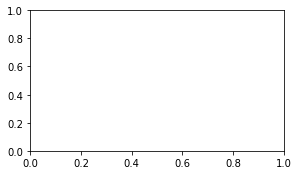

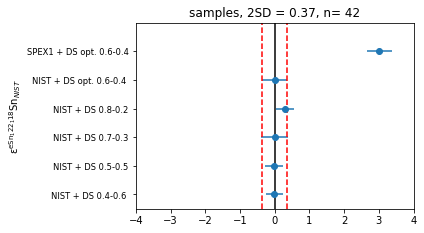

In [90]:
#sel_ratio = ["116/118", "117/118", "119/118", "120/118", "122/118", "124/118"]
#sel_ratio = ["116/117", "118/117", "119/117", "120/117", "122/117", "124/117"]
sel_ratio = ["eSn_122_118"]
#sel_ratio = ["112/120", "114/120", "115/120"]
#sel_ratio = ["112/118", "114/118", "115/118"]
xlim = [-4, 4]

fig = plt.figure(figsize=(10,15))

for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS opt. 0.6-0.4 ", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#savefig(path+"epsilon_x_bgd_118_2_100ppb.pdf", bbox_inches='tight')

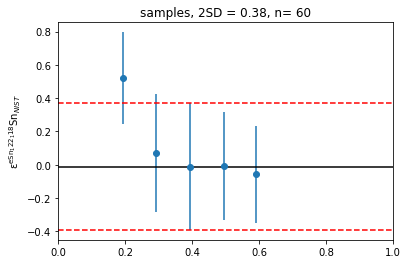

In [199]:
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")]["fspike"]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")]["eSn_122_118"]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")]["eSn_122_118"]["SD2"], ls='none', marker="o")
plt.title("samples" + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std]["eSn_122_118"].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std]["eSn_122_118"].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std]["eSn_122_118"].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std]["eSn_122_118"].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std]["eSn_122_118"].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std]["eSn_122_118"].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std]["eSn_122_118"].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+"eSn_122_118"+'}}$Sn$_{NIST}$')
plt.show()

In [38]:
df_all.to_csv(path + "Signals_zero_mix.csv")

In [200]:
df_DS_inv_mean_sd.to_csv(path + "DS_inv_bgd_corr_mix_no_interf_corr.csv")

In [201]:
df_DS_inv_sub.to_csv(path + "DS_inv_bdg_corr_all_mix_no_interf_corr.csv")

In [68]:
# For one datapoint
files_1 = 7208

df = NU_data_read(path, sample, cup_config)
cycles = range(1, len(df.data_read(sample).index)+1)

# arbitrary blank positions
#blk1 = [item for item in blk_ls if item < sample]
#blk2 = [item for item in blk_ls if item > sample]
#blk1 = blk1[-1]
#blk2 = blk2[0]
#blk_corr_sample = True
    
if (blk_corr == True) and (blk_corr_sample == True):
    blk_1 = NU_data_read(path, blk1, cup_config)
    blk_2 = NU_data_read(path, blk2, cup_config)
    df_zero = df.data_zero_corr(sample)
    df_bgd_1 = blk_1.data_zero_corr(blk1)
    df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
    df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
    df_bgd_corr = new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    #new_corr.line2_corr(df_bgd_corr, "119")
else:
    df_zero = df.data_zero_corr(sample)
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    #new_corr.line2_corr(df_zero, "119")

data_sample = new_corr.raw_ratios(denom_isotope)
data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
df_zero

{'cycle1': {'Ax (1)': Counter({1: 0.00013836589999999954,
           2: 0.00012571850000000009,
           3: 0.00014383660000000069,
           4: 0.00014579099999999928,
           5: 0.00014788939999999841,
           6: 0.00014835819999999868,
           7: 0.00015420509999999887,
           8: 0.00015245509999999886,
           9: -4.0447400000000883e-05,
           10: 0.00014881189999999857,
           11: 0.00012035759999999909,
           12: 0.00014608449999999919,
           13: 0.00012900490000000014,
           14: 0.0003078537999999997,
           15: 0.00014112969999999919,
           16: 0.00014536620000000014,
           17: 0.00013632270000000016,
           18: 0.00014228219999999972,
           19: 0.00012344829999999876,
           20: 0.00012890919999999917}),
  'H1 (1)': Counter({1: 9.6512528109999991,
           2: 9.5990288110000002,
           3: 9.5930372110000004,
           4: 9.5689413110000014,
           5: 9.4110702110000002,
           6: 9.63697051100

In [69]:
#Spike Calculation uncorrected
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc = data_spike_obj.dspike_corr(3, 6, -0.1, -2, 'x')
beta = data_spike_calc["frac_ins_x2.5"]
beta

0    -1.510864
1    -1.508789
2    -1.508917
3    -1.506711
4    -1.505094
5    -1.511240
6    -1.512046
7    -1.509094
8     1.503680
9    -1.522139
10   -1.505025
11   -1.506463
12   -1.507148
13   -1.841712
14   -1.503643
15   -1.508317
16   -1.505471
17   -1.505653
18   -1.501966
19   -1.499314
Name: frac_ins_x2.5, dtype: float64

In [70]:
data_spike_calc

,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,b_nat0,c_nat0,m0.0:x,...,e_nat2,f_nat2,g_nat2,a_ins2,b_ins2,c_ins2,Nr2:x,Nr2:y,Nr2:z,frac_nat_x2
0,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619120,...,-4.404098,1.735338,-0.293320,0.251475,0.240988,-0.185533,3.157274,0.603449,0.753868,-0.018641
1,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,-4.403804,1.735305,-0.293300,0.251451,0.240961,-0.185511,3.157212,0.603391,0.753767,-0.020938
2,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619126,...,-4.403658,1.735289,-0.293290,0.251439,0.240954,-0.185506,3.157182,0.603362,0.753717,-0.022083
3,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,-4.403766,1.735301,-0.293297,0.251448,0.240956,-0.185507,3.157204,0.603383,0.753754,-0.021240
4,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619121,...,-4.403263,1.735245,-0.293264,0.251407,0.240918,-0.185476,3.157099,0.603284,0.753582,-0.025160
5,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619135,...,-4.403640,1.735287,-0.293289,0.251438,0.240958,-0.185509,3.157178,0.603358,0.753711,-0.022219
6,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619148,...,-4.403778,1.735302,-0.293298,0.251450,0.240974,-0.185522,3.157207,0.603385,0.753758,-0.021144
7,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619166,...,-4.403734,1.735297,-0.293295,0.251447,0.240975,-0.185523,3.157198,0.603377,0.753743,-0.021482
8,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.579143,...,-5.048140,1.804461,-0.335064,0.305595,0.271258,-0.210512,3.288068,0.736609,0.994117,4.753254
9,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619386,...,-4.399025,1.734778,-0.292982,0.251067,0.240709,-0.185304,3.156210,0.602448,0.752131,-0.058280


In [71]:
data_corr = {}
data_corr_raw = {}
cycle_no = 20
cycles = range(0, len(data_sample.index))

spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    
    #data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')


In [72]:
spike_corr

{1: {'118': 0.61912006113889029,
  '122': 0.81813878936573747,
  '124': 0.16732120064277978},
 2: {'118': 0.61911425168525391,
  '122': 0.81805517367790703,
  '124': 0.1672851940216227},
 3: {'118': 0.61912628974194117,
  '122': 0.81805195573888878,
  '124': 0.1672793221099298},
 4: {'118': 0.61911404608763743,
  '122': 0.81798069012325936,
  '124': 0.16726362958883415},
 5: {'118': 0.61912080426918348,
  '122': 0.81790354598387227,
  '124': 0.16722271311813908},
 6: {'118': 0.61913509399426914,
  '122': 0.81813101822741197,
  '124': 0.16729994458236438},
 7: {'118': 0.61914757992317704,
  '122': 0.81816441621570202,
  '124': 0.16731911851154876},
 8: {'118': 0.61916617794426432,
  '122': 0.81805887151409529,
  '124': 0.16729603930839582},
 9: {'118': 0.5791433497747327,
  '122': 0.74595684179471722,
  '124': 0.16880522537091386},
 10: {'118': 0.6193856353460705,
  '122': 0.8182938239108356,
  '124': 0.16717424799163497},
 11: {'118': 0.61913683769205263,
  '122': 0.81790057198446653,


In [73]:
data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')

In [75]:
data_corr_raw

,122,124,118
1,0.818139,0.167321,0.619120
2,0.818055,0.167285,0.619114
3,0.818052,0.167279,0.619126
4,0.817981,0.167264,0.619114
5,0.817904,0.167223,0.619121
6,0.818131,0.167300,0.619135
7,0.818164,0.167319,0.619148
8,0.818059,0.167296,0.619166
9,0.745957,0.168805,0.579143
10,0.818294,0.167174,0.619386


In [79]:
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc_2 = data_spike_obj.dspike_corr(3, 6, -0.1, -2.2, 'x')
data_spike_calc_2["eSn"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)

In [80]:
data_spike_calc_2

,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,b_nat0,c_nat0,m0.0:x,...,f_nat2,g_nat2,a_ins2,b_ins2,c_ins2,Nr2:x,Nr2:y,Nr2:z,frac_nat_x2,eSn
0,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619120,...,1.735336,-0.293319,0.251475,0.240987,-0.185532,3.157272,0.603447,0.753864,-0.018726,-1.592763
1,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,1.735305,-0.293300,0.251451,0.240961,-0.185511,3.157213,0.603391,0.753768,-0.020908,-1.778381
2,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619126,...,1.735287,-0.293289,0.251438,0.240953,-0.185505,3.157179,0.603359,0.753712,-0.022195,-1.887829
3,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,1.735298,-0.293296,0.251446,0.240954,-0.185505,3.157199,0.603378,0.753745,-0.021441,-1.823652
4,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619121,...,1.735246,-0.293264,0.251407,0.240918,-0.185476,3.157099,0.603284,0.753582,-0.025148,-2.138903
5,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619135,...,1.735285,-0.293288,0.251437,0.240957,-0.185508,3.157175,0.603355,0.753705,-0.022338,-1.899962
6,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619148,...,1.735302,-0.293298,0.251450,0.240974,-0.185522,3.157207,0.603385,0.753757,-0.021152,-1.799092
7,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619166,...,1.735297,-0.293295,0.251446,0.240975,-0.185522,3.157196,0.603375,0.753740,-0.021542,-1.832220
8,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data_spike_calc_2.to_csv(path+"test_2.csv")

eSn           n0:x          n0:y           n0:z  \
                            mean  SD2      mean  SD2     mean  SD2      mean   
sample                                                                         
DS-NIST Mix 1ppm opti. -1.803065  0.0  3.157775  0.0  0.60392  0.0  0.754685   

                                N0:x      ...  frac_nat_x2            122  \
                        SD2     mean  SD2 ...         mean  SD2      mean   
sample                                    ...                               
DS-NIST Mix 1ppm opti.  0.0  3.15509  0.0 ...    -0.021199  0.0  9.636478   

                                  124            118             117       
                        SD2      mean  SD2      mean  SD2       mean  SD2  
sample                                                                     
DS-NIST Mix 1ppm opti.  0.0  1.971941  0.0  7.302154  0.0  11.789357  0.0  

[1 rows x 634 columns]